# Bayesian Power Analysis for A/B Testing 

### Background

A/B testing is a critical tool for informing decisions, whether comparing webpages, app features, or marketing campaigns. The goal is to identify which version performs best based on a chosen metric like conversion rate, click-through rate, or revenue. For frequentists, A/B testing often involves Null Hypothesis Significance Testing (NHST), where concepts such as  $α$, $p-\text{value}$, and power analysis are central. My focus here is on power analysis.


#### Frequentist power analysis: a brief critique
In Frequentist Statistics, power analysis is essential during the planning phase of an experiment. Frequentist power is defined as the probability of correctly rejecting a false null hypothesis, which is often equated to the probability of correctly identifying a true effect. It's used to determine the minimum sample size required for a study to have a reasonable chance (typically 80% or higher) of detecting a statistically significant effect of a given size at a predetermined significance level (α, often 0.05). This helps researchers avoid underpowered studies that might fail to detect real effects and informs decisions about resource allocation.

The standard definition of frequentist power (the probability of rejecting a false null hypothesis) is framed within a $P(D∣H)$ perspective. It asks: "If the null hypothesis is indeed false (meaning a true effect exists), what is the probability that statistical testing will produce data that leads to rejecting that null hypothesis?" In my opinion, this is a risky and often flawed approach due to its incorrect use of probability for inference. This topic is beyond the scope of this post, but interested readers are invited to consult Aubrey Clayton's "Bernoulli's Fallacy" for a deeper technical and historical dive into this issue.

#### The Bayesian Alternative
The point is that Bayesian analysis offers a compelling alternative to the frequentist approach for A/B testing. It provides more direct and intuitive interpretations of results, without concerns about stopping issues, p-hacking, or needing multiple comparison corrections. Instead of focusing on the probability of observing data under a null hypothesis, Bayesian methods yield the probability distribution of the parameters of interest (e.g., the conversion rates of each variant and their difference). This allows for direct statements about the probability that one variant is better than the other, or the probability that the difference exceeds a practically significant threshold.

Nevertheless, power analysis can still be important in the Bayesian paradigm. While it takes on an altered meaning, it remains essential in experiment planning. Specifically, the goal is to determine the sample size, and consequently, adequate resource allocation to collect so that the experiment has a high probability of yielding informative results. Typically, this means assessing the probability of obtaining posterior distributions with sufficient precision (e.g., narrow credible intervals) or the probability that the effect size (the difference between the variants) exceeds a Minimum Detectable Effect (MDE). In practice, this means simulating potential experiment outcomes for a variety of sample sizes and analyzing the resulting posterior distributions.

### Brief Demonstration of Bayesian Power Analysis
>👉 [Here is the notebook with all the code](https://github.com/erdemkarakoylu/erdemkarakoylu.github.io/blob/main/blog/bayesian_power/bayesian_power.ipynb)

#### Step 1: Define Goal and Metric(s)

Company X wants to increase the conversion rate on its landing page. To do so a new landing page is proposed.  Thus we have
* Current landing page; hereafter referred to as `A`
* Proposed landing page; hereafter referred to as `B`
* A single primary metric, `conversion rate` (number of conversions / total landings )

Obviously this is an oversimplified example but will serve to illustrate the approach.

### Step 2: Eliciting prior beliefs

To compute posteriors I need to combine likelihoods obtained with data with priors. Unlike  Frequentist settings, Bayesian experiments are not conducted in a vaccum. Instead the paradigm encourages the incorporation of prior knowledge. While it is often the case that data will swamp out priors, there is value in carefully constructing them.   

Company X data scientists should therefore base their priors on any relevant existing knowledge. This could include:

1. **Historical Data:** If Company X has run similar A/B tests in the past on the same website or for similar features, the results of those tests can provide valuable information for setting priors. For example, if previous versions of the landing page had conversion rates consistently around 4-6%, this could inform the prior for variant A.

2. **Industry Benchmarks:** Depending on the industry, there might be typical conversion rate ranges that can inform the priors.

3. **Expert Opinions:** Marketing experts or product managers within Company X might have intuitions or expectations about the performance of the new variant B. These subjective beliefs can be formalized into a prior distribution.

4. **A "Skeptical" or Weakly Informative Prior:** If Company X has little to no prior information, they might choose a weakly informative prior. This is a prior that doesn't strongly favor any particular outcome but still provides some regularization. 


The outcome is binary, thus the natural likelihood to model the data is the Binomial distribution. There a few distributions that can be used to encode priors. To keep things simple and avoid reaching to my favorite MCMC sampler, I define priors in terms of Beta distributions. A Beta distribution is a conjugate prior to the Binomial, meaning that updating the posterior has a closed form and does not require approximation. The parameters $α$ and $β$ of the Beta distribution represent prior "successes" and "failures," respectively. A higher $α$ relative to $β$ shifts the distribution towards higher values, and vice versa. The sum of $α$ and $β$ influences the "strength" or concentration of the prior belief (higher sum means more certainty). Below I show what this might look like.

In [49]:
from dataclasses import dataclass
import arviz as az
import numpy as np
import matplotlib.pyplot as pp
from preliz.distributions import beta
from scipy.stats import beta as sp_beta
from loguru import logger

* Here I assume a conversion of 5% for variant $A$, so that is what I'll use for $A$'s prior. 
* Without any additional information and to keep things simple a reasonable prior for $A$ is therefore $p(A)=Beta(α=5, β=95)$. 
* I also expect a lift of 1% from variant B so an acceptable prior is $p(B)ß=Beta(α=6, β=94)$.
* Note that $Beta(1, 1)$ means 0 successes and 0 failures, But I keep the numbers above instead of bumping them by 1 to make it simpler.

In [ ]:
BASELINE_CONVERSION_A      = 0.05      # control-group conversion rate
MDE             = 0.01      # minimal detectable effect (lift we care about)
TRUE_CONVERSION_B        = 0.07      # assumed true lift 

# --- evidence thresholds ---------------------------------------------
DCT             = 0.95      # Directional Credibility Threshold: P(Δ>0)
PCT             = 0.80      # Practical Credibility Threshold:  P(Δ>MDE)
AT              = 0.80      # Assurance Target (desired power level)

# --- simulation controls ---------------------------------------------
N_DRAWS        = 5_000      # posterior draws per trial
N_SIMULATIONS  = 1_000      # trials per sample-size value
SAMPLE_SIZES   = np.arange(250, 5_250, 250)  # per-arm sizes to sweep

In [ ]:
# A handy way to carry around my updatable priors

@dataclass
class BetaPrior:
    α: float
    β: float
    
# Define Priors
prior_A = BetaPrior(α=5, β=95)
prior_B = BetaPrior(α=6, β=94)

# Define random variables for variants 'A' and 'B'
rv_A = beta.Beta(prior_A.α, prior_A.β)
rv_B = beta.Beta(prior_B.α, prior_B.β)

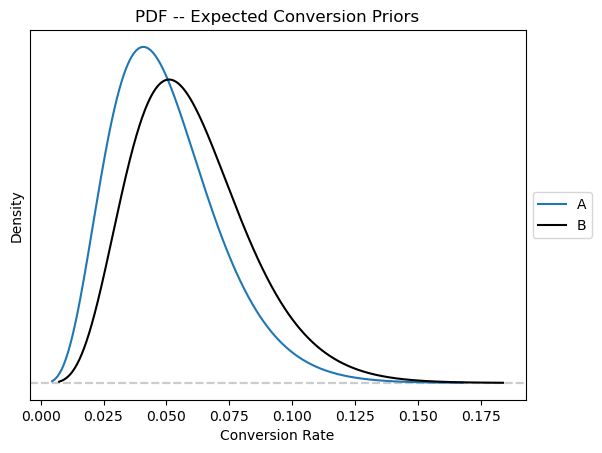

In [12]:
f, ax = pp.subplots()
rv_A.plot_pdf(ax=ax, legend='A')
rv_B.plot_pdf(ax=ax, color='k', legend='B')
ax.set_title('PDF -- Expected Conversion Priors')
ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Density');

* Updating the Beta prior to get the posterior is trivial as it boils down to adding new successes and new failures to the existing $α$ and $β$ parameters, respectively. 
* In the notebook linked below, the function `run_analytical_ab_test` generates the data based on the true conversion rates (A is known)

In [46]:

def run_analytical_ab_test(n_A, n_B, true_p_A, true_p_B, prior_α_A, prior_β_A, prior_α_B, prior_β_B):
    """Runs a simulated A/B test and returns the parameters of the posterior distributions."""
    
    # Simulate observed data
    conversions_A = np.random.binomial(n_A, true_p_A)
    conversions_B = np.random.binomial(n_B, true_p_B)

    # Update posterior parameters analytically
    posterior_α_A = prior_α_A + conversions_A
    posterior_β_A = prior_β_A + n_A - conversions_A
    posterior_α_B = prior_α_B + conversions_B
    posterior_β_B = prior_β_B + n_B - conversions_B

    return (posterior_α_A, posterior_β_A), (posterior_α_B, posterior_β_B)

### Step 3: Defining the Minimum Detectable Effect (MDE)

* Question: what is the smallest <u>practically significant</u> difference in conversion rates that Company X would want to detect?
* The answer is the Minimum Detectable Effect, hereafter MDE. 
* Note the actual effect would need to be greater than the MDE; the greater the actual effect relative to the MDE, the smaller the number of samples needed to detect a difference at the MDE level. 

* Let's assume Company X is interested in detecting an absolute difference of at least 1% in the conversion rate, that's our MDE
* If the baseline conversion rate is around 5%, stakeholders then want to be able to reliably detect if variant B increases it to 6% or more. 
* Given the above and to make it easy on me, let's say that the as of yet still unknown true effect of Variant B will be 7%  - Obviously several such scenarios coould be simulated, but to keep it short we'll just envisage one Variant B conversion rate. 

### Step 4: Prospective Sample Size Planning (Bayesian "Power Analysis")

* We are not trying to calculate the probability of rejecting a null hypothesis  (which wouldn't tell you all that much about the alternative, BTW).
* The focus is on the probability of achieving a desired level of certainty about the difference in conversion rates. 
* This often involves simulating potential outcomes for different sample sizes and evaluating the resulting posterior distribution.
* Thus, we want to determine the sample size that gives us a high probability if B is better than A under the following two conditions:
    * The posterior probability that variant B is better than variant A (i.e., conversion rate of B > conversion rate of A) being above a certain threshold (e.g., 95%).
    * The posterior probability that the difference in conversion rates (B - A) is greater than the MDE being above a certain threshold (e.g., 80%).

* The function below will evaluate the posterior difference for a given number of samples in view of these criteria.

In [ ]:
def evaluate_analytical_power(
        posterior_params_A, posterior_params_B, mde=0.01, prob_threshold=DCT, 
        diff_threshold=PCT, n_samples=10000, verbose=False):
    """Evaluates the probability of a "successful" outcome based on the posterior samples."""
    
    # Generate random samples from the posterior distributions
    posterior_A_samples = sp_beta.rvs(posterior_params_A[0], posterior_params_A[1], size=n_samples)
    posterior_B_samples = sp_beta.rvs(posterior_params_B[0], posterior_params_B[1], size=n_samples)

    # Calculate the difference in conversion rates
    posterior_diff = posterior_B_samples - posterior_A_samples

    prob_B_better_than_A = np.mean(posterior_diff > 0)
    prob_diff_greater_than_mde = np.mean(posterior_diff > mde)
    if verbose:
        logger.info(f"Probability (P(p_B > p_A)): {prob_B_better_than_A:.3f}")
        logger.info(f"Probability (P(p_B - p_A > {mde:.2f})): {prob_diff_greater_than_mde:.3f}")

    return prob_B_better_than_A >= prob_threshold and prob_diff_greater_than_mde >= diff_threshold


2025-06-04 15:33:25.610 | INFO     | __main__:<module>:21 - 
For sample size n = 250 per group, the probability of a 'successful' outcome is: 0.300
2025-06-04 15:33:25.714 | INFO     | __main__:<module>:21 - 
For sample size n = 500 per group, the probability of a 'successful' outcome is: 0.350
2025-06-04 15:33:25.816 | INFO     | __main__:<module>:21 - 
For sample size n = 750 per group, the probability of a 'successful' outcome is: 0.430
2025-06-04 15:33:25.917 | INFO     | __main__:<module>:21 - 
For sample size n = 1000 per group, the probability of a 'successful' outcome is: 0.620
2025-06-04 15:33:26.062 | INFO     | __main__:<module>:21 - 
For sample size n = 1250 per group, the probability of a 'successful' outcome is: 0.590
2025-06-04 15:33:26.164 | INFO     | __main__:<module>:21 - 
For sample size n = 1500 per group, the probability of a 'successful' outcome is: 0.650
2025-06-04 15:33:26.266 | INFO     | __main__:<module>:21 - 
For sample size n = 1750 per group, the probabil

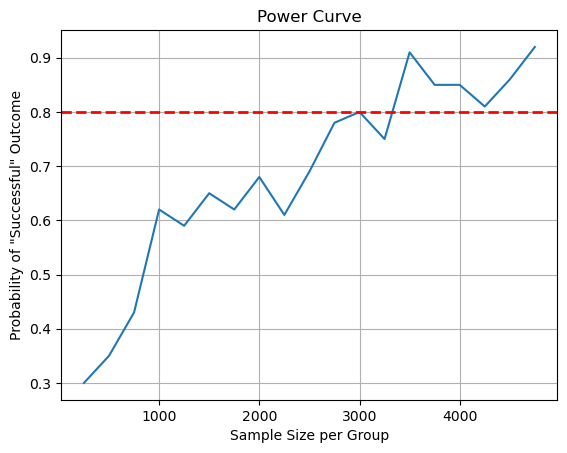

In [ ]:
power_estimates = []
for n in SAMPLE_SIZES:
    successes = 0
    for _ in range(N_SIMULATIONS):
        posterior_params_A, posterior_params_B = run_analytical_ab_test(
            n, n, BASELINE_CONVERSION_A, TRUE_CONVERSION_B, prior_A.α, prior_A.β, prior_B.α, prior_B.β
        )
        if evaluate_analytical_power(posterior_params_A, posterior_params_B, mde=MDE):
            successes += 1
    power = successes / N_SIMULATIONS
    power_estimates.append(power)
    logger.info(f"\nFor sample size n = {n} per group, the probability of a 'successful' outcome is: {power:.3f}")

# Plot the "power" curve
pp.plot(SAMPLE_SIZES, power_estimates)
pp.xlabel('Sample Size per Group')
pp.ylabel('Probability of "Successful" Outcome')
pp.title('Power Curve')
pp.grid(True)
pp.axhline(AT, color='r', ls='--', lw=2)

### Power Analysis Interpretation
* The figure above suggests 3500 FOR EACH variant would be a sufficient size. 
* I recommend running it a bunch of times and get uncertainty envelopes aroound these numbers for added credibility to threshold surpassing.

The curve above is made of point estimates, which are something to be wary off. To make it a bit more realistic the process is repeated below. However, instead of having a fixed parameters for expected  $p(A)$ and $p(B)_{true}$. Instead I next introduce proto-priors; distributions based on what is known about A and B and from which we'll draw



### Running The Actual Experiment.
* Armed with this information we can actually run an A/B test and see what kind of posterior we get. 
* Note that unlike Frequentists we don't have traditionally accepted significance levels. How to come to a decision is an important discussion point between  the data scientist and the stakeholder/decision maker.
* As a decision guide as to whether the difference is significantly greater than 0, I propose a Region of Pratical Equivalence (ROPE).
* Determining a good ROPE is beyond the scope of this post. But the power analysis had two criteria so for illustration, I will use these as follows
* First ROPE will be between (-1 and 0.005) and I will visually evaluate whether 95% of the Highest Density Interval (HDI) of the posterior of the difference (B-A) is greater
* Second rope will be between (0 and 0.015) and I will visually evaluate whether 80% of the HDI of the same posterior is greater. 
* Note that for both I left some wiggle room and bumped the ROPE's upper limits by half a percent relative to the Power Analysis criteria

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
2025-06-04 16:23:14.858 | INFO     | __main__:<module>:41 -              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
p_A         0.045  0.003   0.038    0.051        0.0      0.0   9888.245   
p_B         0.071  0.004   0.063    0.079        0.0      0.0  10112.760   
difference  0.026  0.006   0.016    0.037        0.0      0.0   9924.811   

             ess_tail  r_hat  
p_A          9559.776    NaN  
p_B          9837.409    NaN  
difference  10044.471    NaN  
2025-06-04 16:23:14.860 | INFO     | __main__:<module>:46 - 
Posterior probability (P(p_B > p_A) | data): 1.000
2025-06-04 16:23:14.860 | INFO     | __main__:<module>:47 - Posterior probability (P(p_B - p_A > 0.01) | data): 0.998


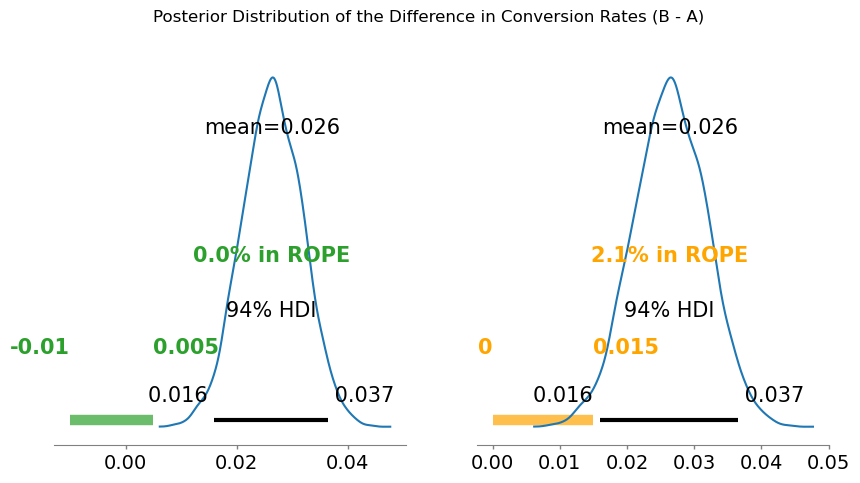

In [76]:

# --- Analyzing actual data analytically ---
actual_n_A = 3500 # number of samples determined via power analysis
actual_n_B = 3500
posteriro_draws = 10000 # This is the number of samples we'll draw from each posterior
rope_1 = (-0.01, 0.005) 
rope_2 = (0, 0.015)

actual_conversions_A = np.random.binomial(actual_n_A, 0.05)
actual_conversions_B = np.random.binomial(actual_n_B, 0.07)

posterior_params_A_actual = (prior_A.α + actual_conversions_A, prior_A.β + actual_n_A - actual_conversions_A)
posterior_params_B_actual = (prior_B.α + actual_conversions_B, prior_B.β + actual_n_B - actual_conversions_B)

# Generate posterior samples for plotting with ArviZ
posterior_A_samples_actual = sp_beta.rvs(posterior_params_A_actual[0], posterior_params_A_actual[1], size=10000)
posterior_B_samples_actual = sp_beta.rvs(posterior_params_B_actual[0], posterior_params_B_actual[1], size=10000)
posterior_diff_actual = posterior_B_samples_actual - posterior_A_samples_actual

idata = az.from_dict(
    posterior={"p_A": posterior_A_samples_actual, "p_B": posterior_B_samples_actual, "difference": posterior_diff_actual}
)

f, ax = pp.subplots(ncols=2, figsize=(10, 5))
az.plot_posterior(
    idata, 
    var_names=['difference'], 
    rope=rope_1, ax=ax[0]
    )
ax[0].set_title('')
az.plot_posterior(
    idata, 
    var_names=['difference'], 
    rope=rope_2, ax=ax[1], rope_color='orange', 
    )
ax[1].set_title('')

#ax[0].set_xlim(ax[1].get_xlim())
f.suptitle('Posterior Distribution of the Difference in Conversion Rates (B - A)')

summary_df = az.summary(idata, var_names=['p_A', 'p_B', 'difference'], round_to=3)
logger.info(summary_df)

prob_B_better_than_A_actual = np.mean(posterior_diff_actual > 0)
prob_diff_greater_than_mde_actual = np.mean(posterior_diff_actual > MDE)

logger.info(f"\nPosterior probability (P(p_B > p_A) | data): {prob_B_better_than_A_actual:.3f}")
logger.info(f"Posterior probability (P(p_B - p_A > {MDE:.2f}) | data): {prob_diff_greater_than_mde_actual:.3f}")

Figure above:
* Both plots above show the same posterior with different ROPEs
* In black, the chosen HDI - 94% in this case as a reminder to be practical, not religious about these numbers
* Numbers in black are lower and upper HDI bounds, and posterior mean.  
* Left panel shows 0% of the posterior  overlaps with the ROPE, which satisfies the condition that $P((B-A)>0) > 95\%$. 
* Right panel shows shows 2.1% of the posterior overlaps with the ROPE, meaning $P((B-A)>0.01)=97.1\%>80\%$

### In conclusion
Power analysis is not a strict necessity for Bayesians. It's OK for us to go and collect more data if the posterior is not what we want it to be -  data snooping or p-hacking is not a thing here. Nevertheless it can still be a useful tool for experiment planning and adequate resource allocation.
Thanks for reading & happy (probabilistic) coding!